# Лабораторная работа 10
Реализовать решение уравнения теплопроводности по двум схемам: одной из неявных и явной.\
Посмотреть на поведение решения по явной схеме при несоблюдении условий устойчивости.\
Результаты выводить либо графически (поверхность), либо численно (матрицу значений).\
Уравнение теплопроводности: $$u_t(x, t) = ku_{xx}(x,t)+f(x,t).$$

In [142]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.linalg import hilbert
import unittest
from parameterized import parameterized, parameterized_class
from tabulate import tabulate
import numpy.testing
import matplotlib as mpl
import functools
import scipy as sp
import scipy.special
import scipy.misc
import scipy.integrate
from matplotlib import cm
from colorama import Fore

plt.style.use('default')
sns.color_palette('bright')

from math import sin, exp, sqrt, cos, log

## Реализация явной схемы

In [143]:
def grid(a, b, N):
    return np.linspace(a, b, N)

def imply_boundary_conditions(u, a, T, N_x, N_t):
    x_grid = grid(0, a, N_x + 1)
    t_grid = grid(0, T, N_t + 1)

    U = np.zeros((N_x + 1, N_t + 1))

    for i in range(N_x + 1):
        U[i, 0] = u(x_grid[i], 0)
    for i in range(N_t + 1):
        U[0, i] = u(x_grid[0], t_grid[i])
        U[N_x, i] = u(x_grid[N_x], t_grid[i])

    return x_grid, t_grid, U

def explicit(u, k, f, a, T, N_x, N_t, return_grids=True):
    # 0 <= x <= a, 0 <= t <= T
    x_grid, t_grid, U = imply_boundary_conditions(u=u, a=a, T=T, N_x=N_x, N_t=N_t)
    tau =  T / N_t
    h = a / N_x

    if not 2 * k * tau <= h**2:
        print(Fore.RED + 'Явная схема неустойчива!')

    for t in range(1, N_t + 1):
        for x in range(1, N_x):
            diff = U[x - 1, t - 1] - 2 * U[x, t - 1] + U[x + 1, t - 1]
            U[x, t] = U[x, t - 1] + tau * (k / h**2 * diff + f(x_grid[x], t_grid[t - 1]))

    if return_grids:
        return x_grid, t_grid, U
    else:
        return U

## Реализация чисто неявной схемы ($\sigma = 1$)

In [144]:
def implicit(u, k, f, a, T, N_x, N_t, return_grids=True):
    x_grid, t_grid, U = imply_boundary_conditions(u=u, a=a, T=T, N_x=N_x, N_t=N_t)
    tau =  T / N_t
    h = a / N_x

    for t in range(1, N_t + 1):
        lhs = np.zeros((N_x + 1, N_x + 1))
        rhs = np.zeros(N_x + 1)

        lhs[0, 0] = -(tau * k / h + 1)
        lhs[0, 1] = tau * k / h
        rhs[0] = -U[0, t - 1] - tau * f(x_grid[0], t_grid[t])

        lhs[N_x, N_x] = tau * k / h - 1
        lhs[N_x, N_x - 1] = -tau * k / h
        rhs[N_x] = -U[N_x, t - 1] - tau * f(x_grid[N_x], t_grid[t])

        coef = tau * k / h**2
        for x in range(1, N_x):
            lhs[x, x] = -2 * coef - 1
            lhs[x, x - 1] = lhs[x, x + 1] = coef

            rhs[x] = -U[x, t - 1] - tau * f(x_grid[x], t_grid[t])

        U[:, t] = np.linalg.solve(lhs, rhs)

    if return_grids:
        return x_grid, t_grid, U
    else:
        return U


In [145]:
def plot_for(ax, X, T, Z, title):
    ax.plot_surface(X, T, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('t', fontsize=20)
    ax.set_zlabel('Z', fontsize=20)

def plot(u, k, f, a, T, N_x, N_t):
    fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(30, 10), dpi=80)
    x_grid, t_grid, U_exp = explicit(u=u, k=k, f=f, a=a, T=T, N_x=N_x, N_t=N_t)
    U_imp = implicit(u=u, k=k, f=f, a=a, T=T, N_x=N_x, N_t=N_t, return_grids=False)
    X, T = np.meshgrid(x_grid, t_grid)
    explicit_ax = ax[0]
    implicit_ax = ax[1]

    plot_for(explicit_ax, X, T, U_exp, 'Явная схема')
    plot_for(implicit_ax, X, T, U_imp, 'Неявная схема')

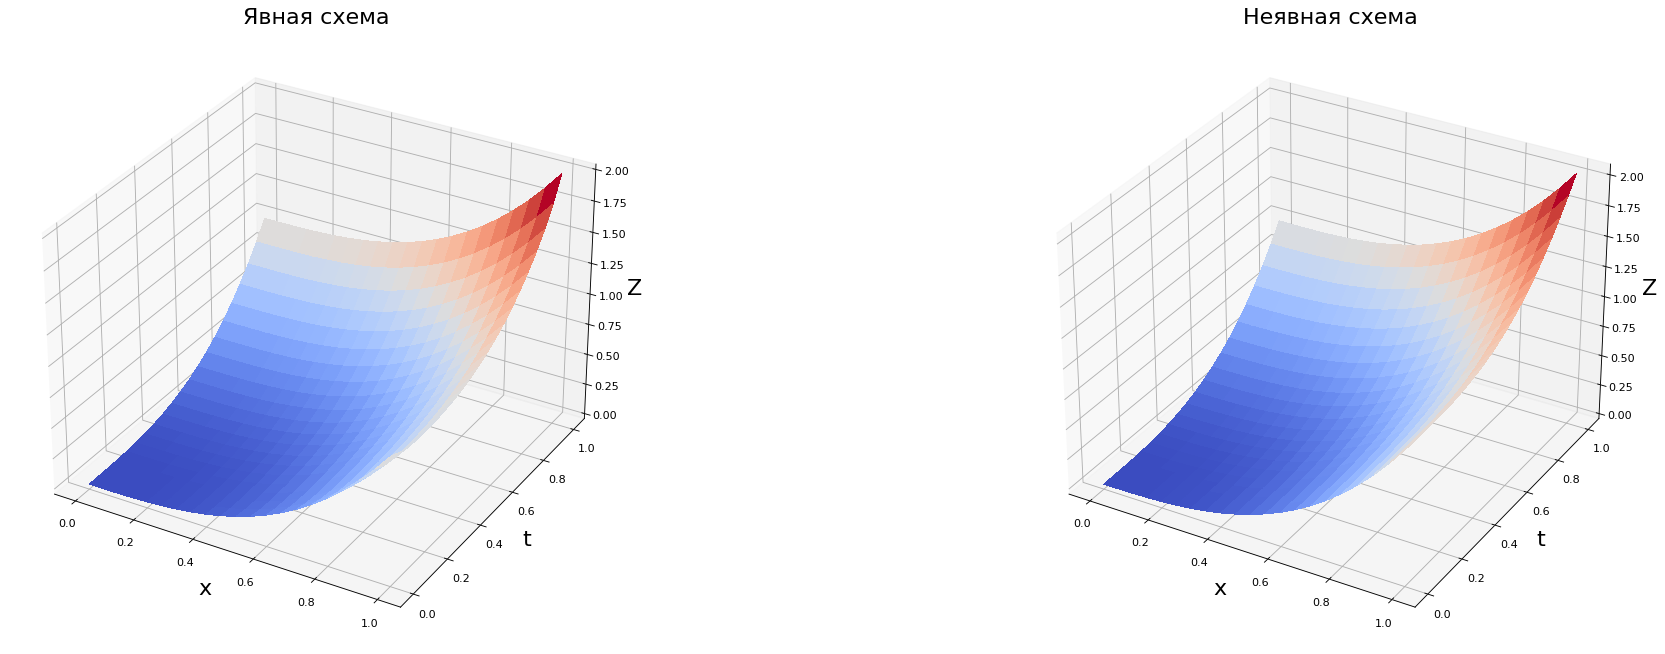

In [146]:
k = 0.01
a = 1
T = 1

u = lambda x, t: x**3 + t**3
f = lambda x, t: 3 * t**2 - k * 6 * x

plot(u, k, f, a, T, 20, 20)

Явная схема неустойчива!


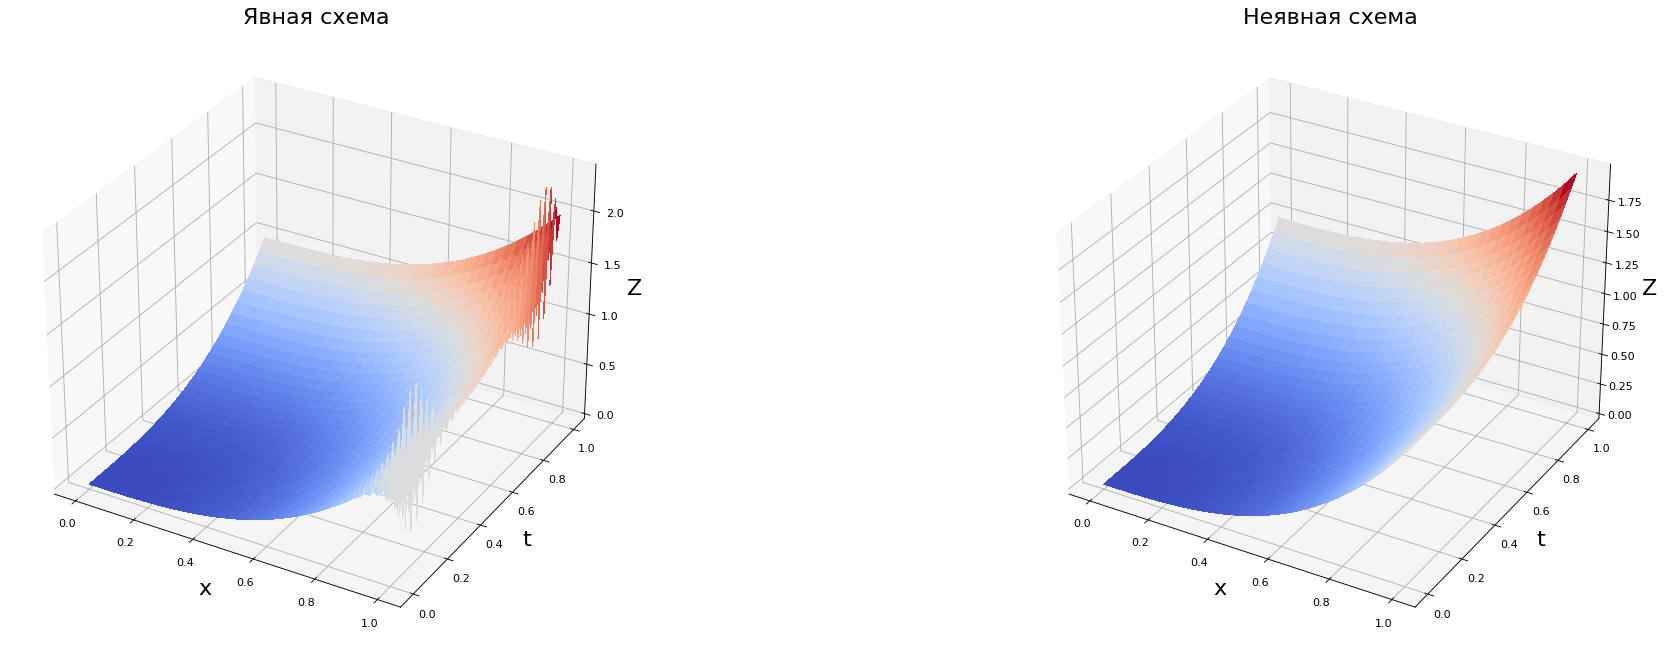

In [147]:
k = 0.01
a = 1
T = 1

u = lambda x, t: x**3 + t**3
f = lambda x, t: 3 * t**2 - k *  6 * x

plot(u, k, f, a, T, 60, 60)

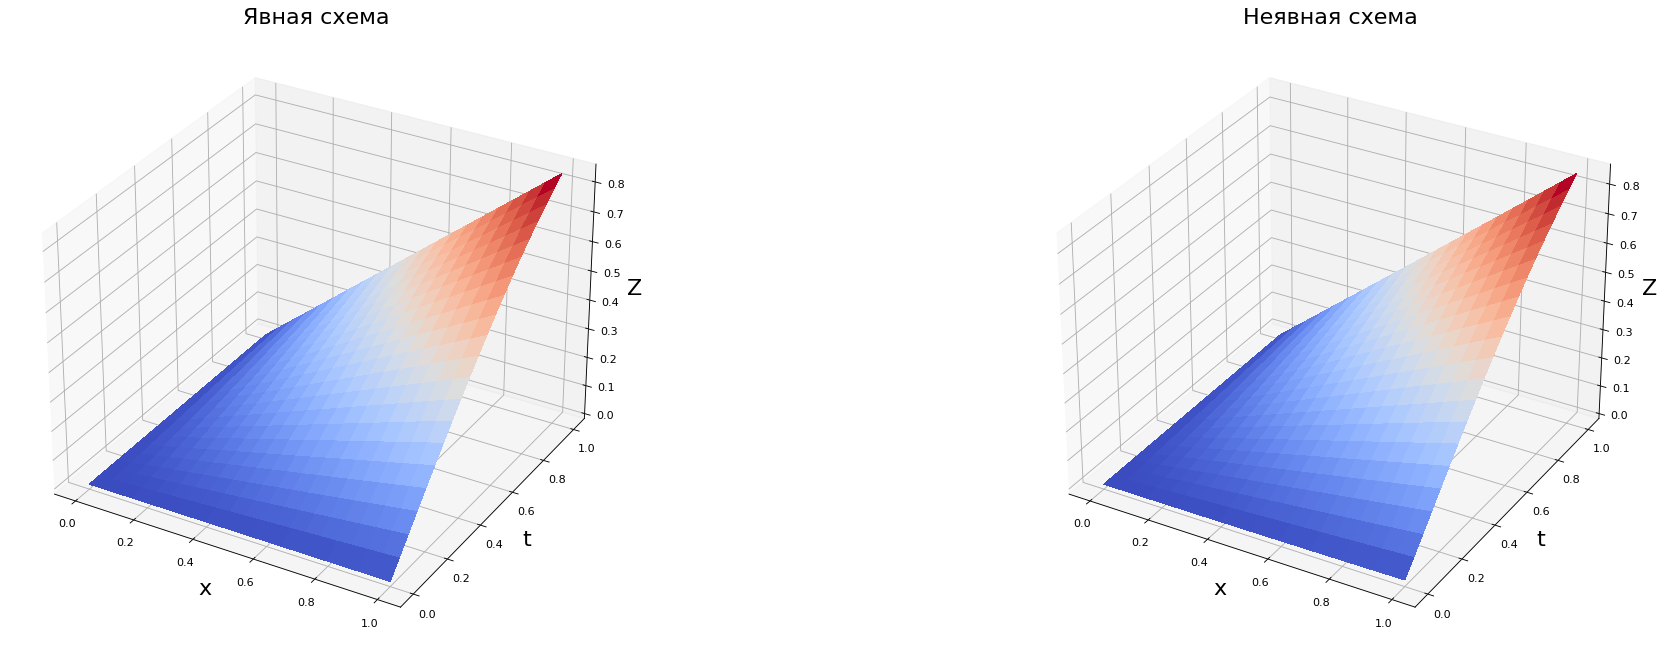

In [148]:
k= 0.01
a = 1
T = 1

u = lambda x, t: t * sin(x)
f = lambda x, t: (1 + k * t) * sin(x)

plot(u, k, f, a, T, 20, 20)

Явная схема неустойчива!


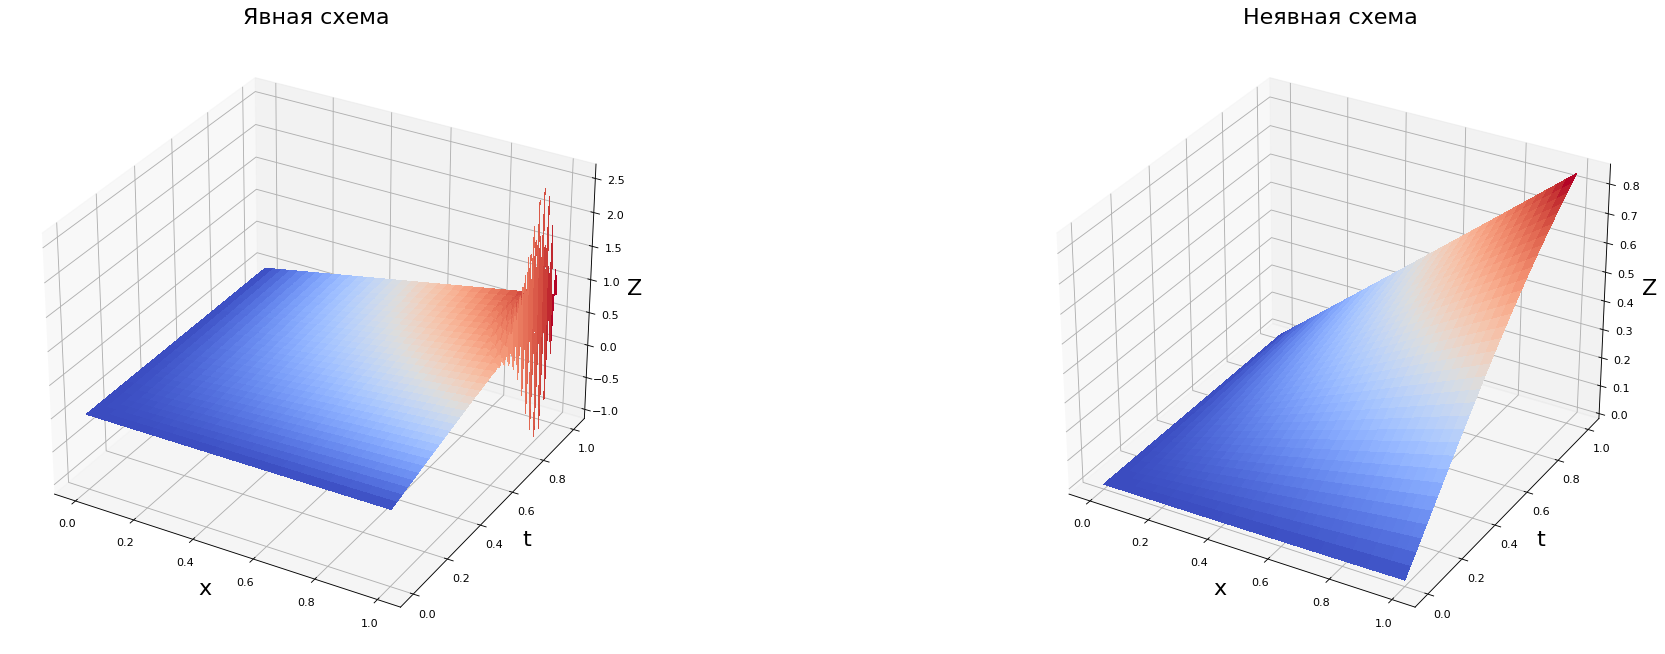

In [149]:
k = 0.01
a = 1
T = 1

u = lambda x, t: t * sin(x)
f = lambda x, t: (1 + k * t) * sin(x)

plot(u, k, f, a, T, 66, 66)

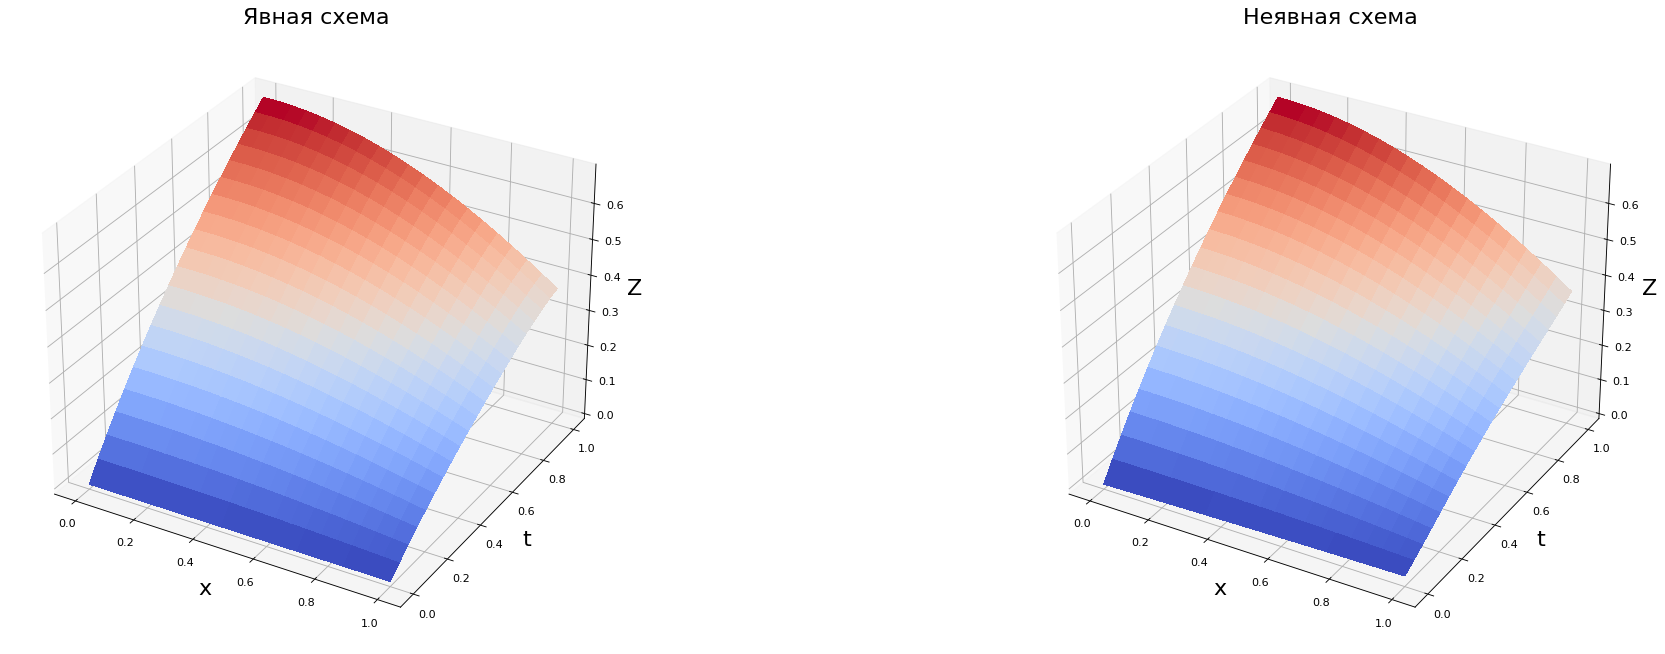

In [150]:
k = 0.01
a = 1
T = 1

u = lambda x, t: cos(t) * log(x + 1)
f = lambda x, t: -sin(t) * log(x + 1) + k * cos(t) / (x + 1)**2

plot(u, k, f, a, T, 20, 20)

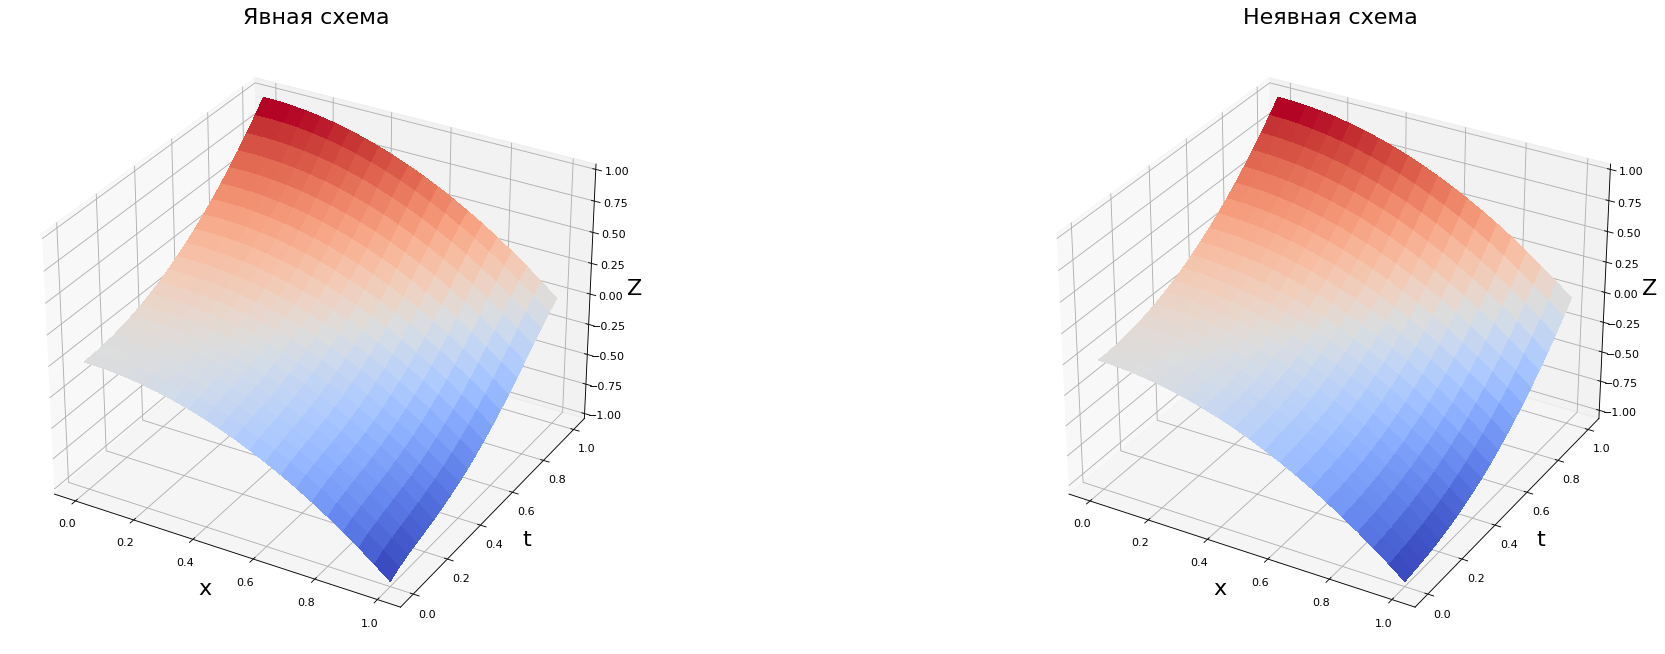

In [151]:
k = 0.01
a = 1
T = 1

u = lambda x, t: x**2 - t**2
f = lambda x, t: 2 * k - 2 * t

plot(u, k, f, a, T, 20, 20)

Явная схема неустойчива!


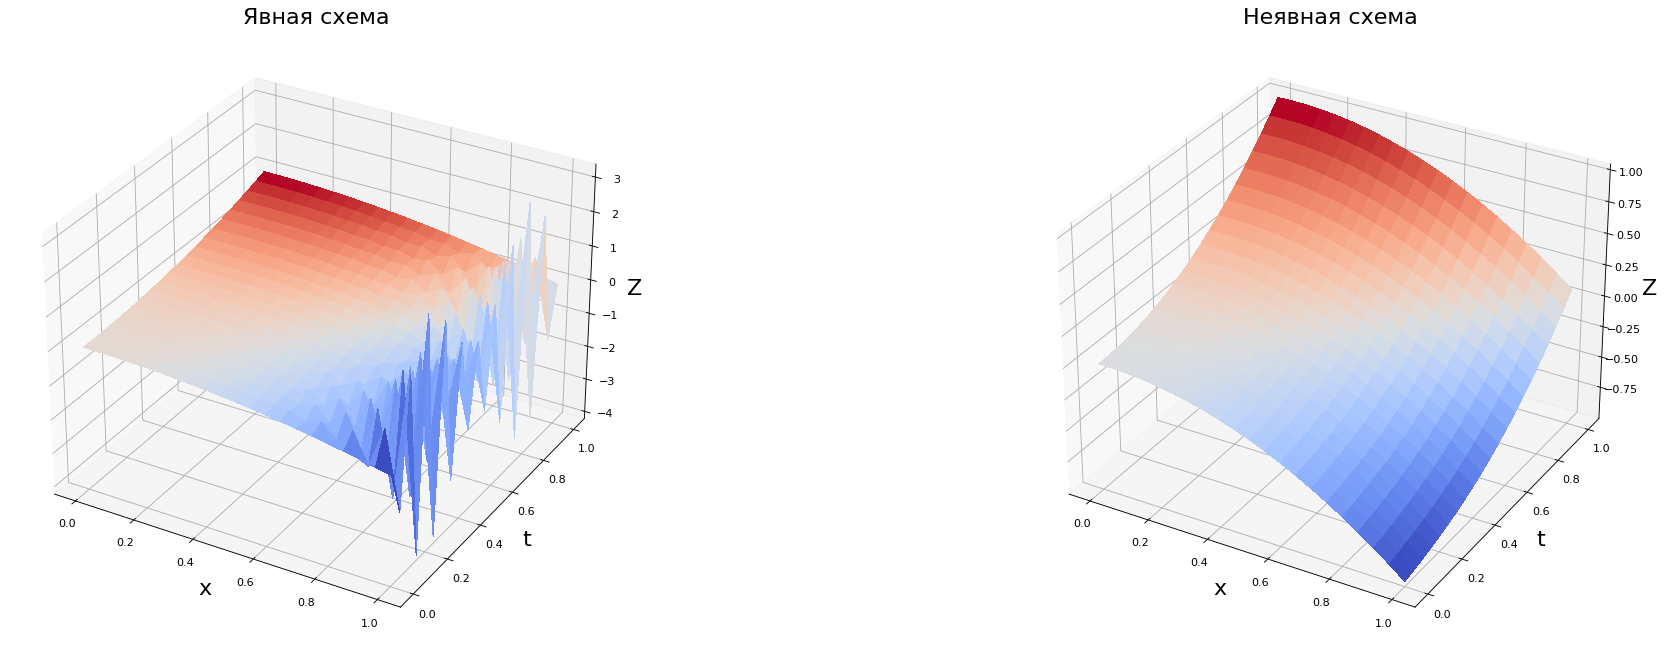

In [152]:
k = 0.035
a = 1
T = 1

u = lambda x, t: x**2 - t**2
f = lambda x, t: 2 * k - 2 * t

plot(u, k, f, a, T, 20, 20)

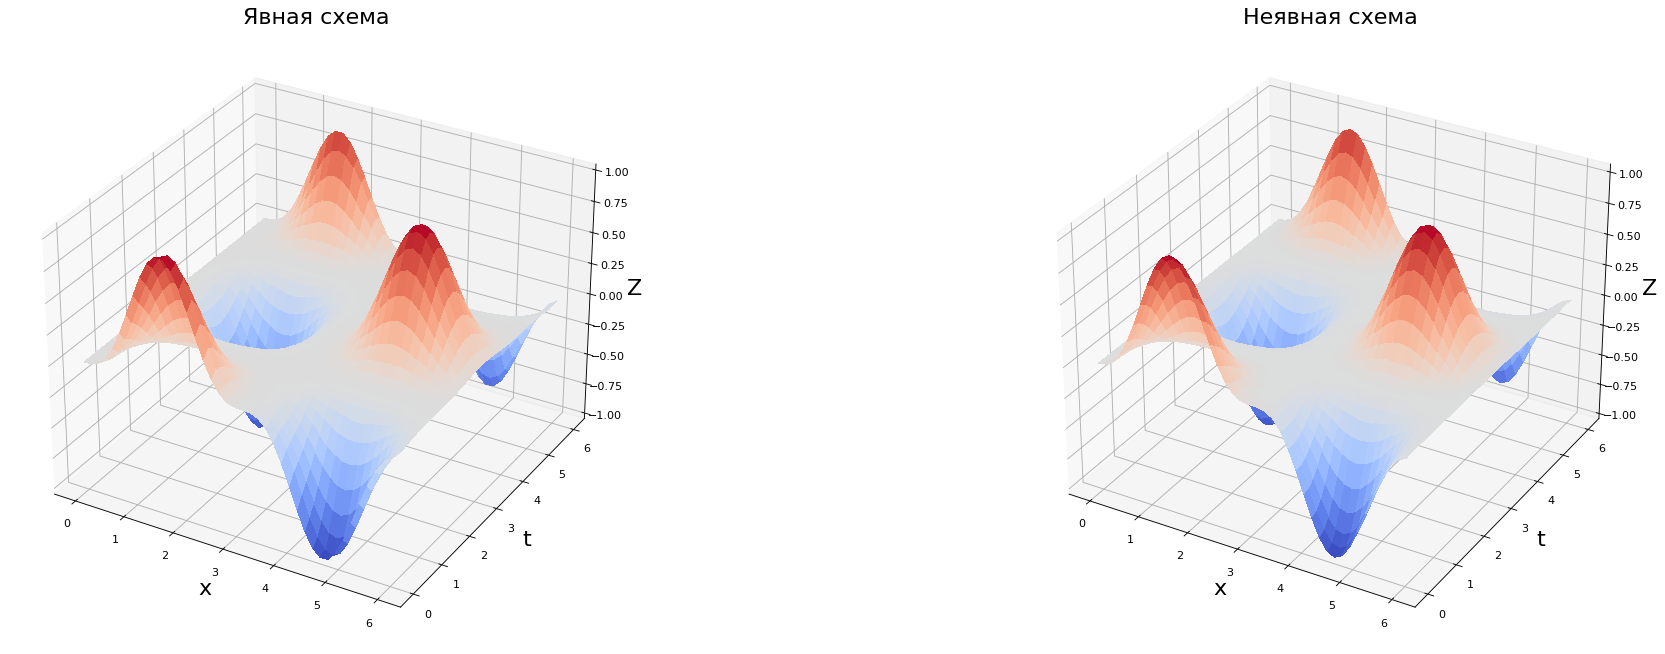

In [153]:
k = 0.01
a = 6
T = 6

u = lambda x, t: sin(t)**3 * cos(x)**3
f = lambda x, t: 3 * sin(t)**2 * (cos(t) * cos(x)**3 + k * sin(t) * (cos(x)**3 - 2 * sin(x)**2 * cos(x)))

plot(u, k, f, a, T, 40, 40)

Явная схема неустойчива!


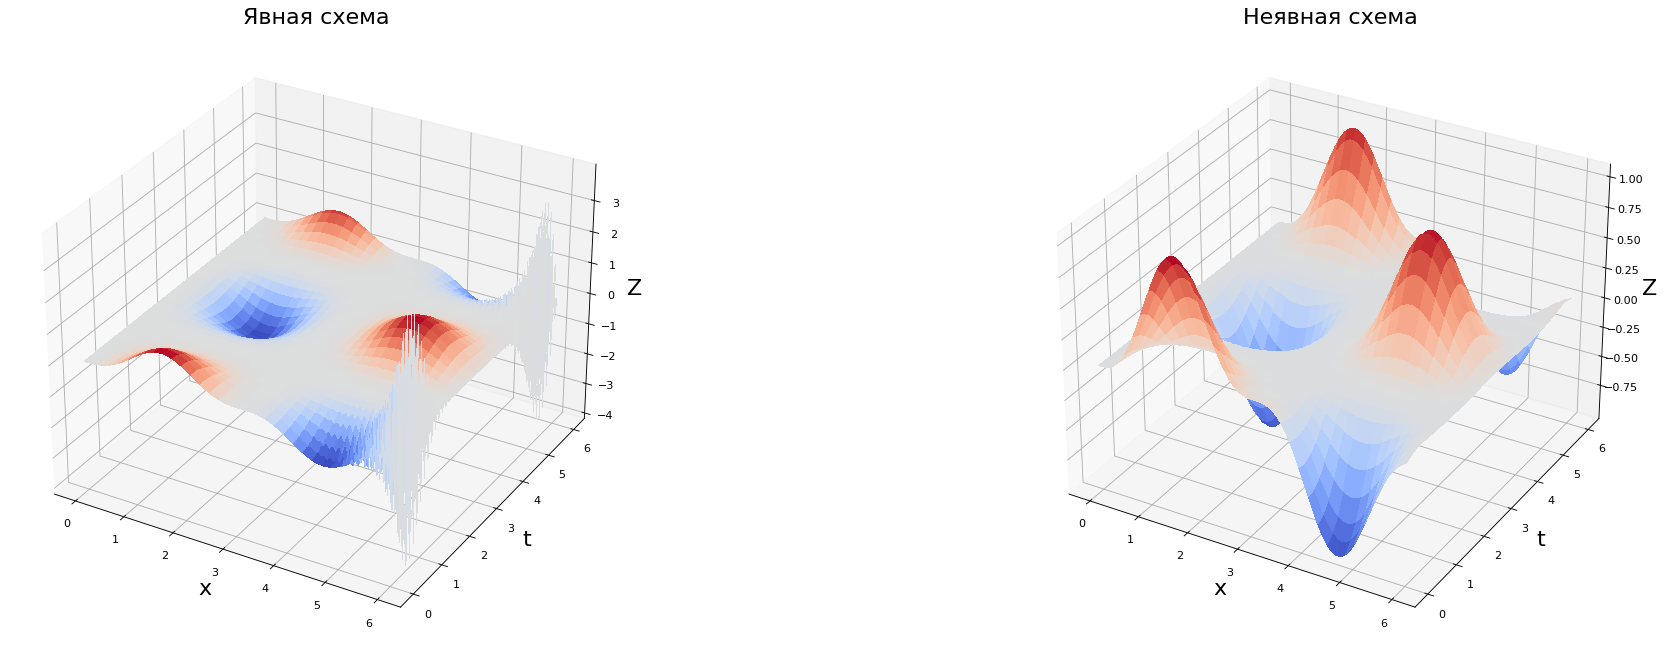

In [154]:
k = 0.033
a = 6
T = 6

u = lambda x, t: sin(t)**3 * cos(x)**3
f = lambda x, t: 3 * sin(t)**2 * (cos(t) * cos(x)**3 + k * sin(t) * (cos(x)**3 - 2 * sin(x)**2 * cos(x)))

plot(u, k, f, a, T, 100, 100)